# Head Velocity
Notebook for clean attempt of checking the distribution of head velocit and stimulus related behavior of the animal.

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate


%matplotlib inline
sns.set(color_codes=True)
pd.options.mode.chained_assignment = None 


# data loading
path = '../datasets/preprocessed/'
# dfrat     = pd.read_hdf(path+'relationalDatabase.h5', 'Rat_Behavior').set_index('index')

dfrat     = pd.read_hdf(path+'filteredDatabase.h5', 'Rat_Behavior').set_index('index')
dfevent   = pd.read_hdf(path+'relationalDatabase.h5', 'Events').set_index('index')
dfsession = pd.read_hdf(path+'relationalDatabase.h5', 'Sessions').set_index('index')

In [2]:
# Applying the Y_Pos LPfilter
dfV = dfrat.copy()
# rearing
rearinglimit = 0.13
dfV = dfV[dfV['Y_Pos'] < rearinglimit]

#cleaning
dfV = dfV[(dfV['Y_Ori'] >-0.75) & (dfV['Y_Pos'] > 0.07)]

In [3]:
## SMOOTHING THE DATA
windowsize = 100
colChoice = ['X_Pos', 'Y_Pos', 'Z_Pos', 'X_Ori', 'Y_Ori', 'Z_Ori']

dfV = dfrat.copy()
g = dfV.groupby('session_id')
dfV[colChoice] = g[colChoice].rolling(window=windowsize).mean().values

dfV.dropna(inplace=True)

## Angular velocity calculations
Calculating vectors, angle, velocity for comparison.

In [4]:
## VECTORS WITHOUT Y
dfOri = pd.DataFrame()

for name, dd in dfV.groupby('session_id'):
    dd['dT'] = dd['Time'].diff(1)
    
    # calculating lenghts of VecX and VecZ and creation of shifted vectors  #dd = dd.apply(decompose_vec_df, axis=1)
    dd['lVo'] = np.linalg.norm(np.array([dd.X_Ori, dd.Y_Ori, dd.Z_Ori])  )
    dd['lx1'] = dd['X_Ori'] / dd['lVo']
    dd['lz1'] = dd['Z_Ori'] / dd['lVo']
    
    # normalize the data to unit vector form
    dd['V1'] = np.linalg.norm(np.array([dd.lx1, 0, dd.lz1]))
    dd['lx1'] = dd.lx1 / dd.V1
    dd['lz1'] = dd.lz1 / dd.V1

    dfOri = pd.concat([dfOri, dd], axis=0, ignore_index=True)

dfOri = dfOri.replace([np.inf, -np.inf], np.nan).dropna()
# print(dfOri)

In [5]:
## ANGLES and VELOCITY
dfOri2 = pd.DataFrame()

# calculatinig the angles between X axis and the vectors
for name, dd in dfOri.groupby('session_id'):
    dd['lx2'] = dd.lx1.shift(1)
    dd['lz2'] = dd.lz1.shift(1)
    
    V1 = np.array([dd.lx1, 0, dd.lz1])
    V2 = np.array([1     , 0, 0     ])
    V3 = np.array([dd.lx2, 0, dd.lz2])
    
    dd['clockwise'] = dd.lz1 * dd.lx2 > dd.lx1 * dd.lz2

    dd.clockwise = dd.clockwise.astype(int)
    dd.clockwise = dd.clockwise.replace(to_replace=0, value=-1)
    dd.clockwise
    
#   theta0 = np.arccos(lx1*1 + lz1*0 / (np.linalg.norm(V1) * np.linalg.norm(V2)))
#     dd['theta0'] = np.arccos(dd.lx1 / (np.linalg.norm(V1) * np.linalg.norm(V2)))
#     dd['theta1'] = dd.theta0.shift(1)    
#     dd['theta']  = dd.theta0 - dd.theta1    
#     dd.drop({'theta0','theta1'}, axis=1, inplace=True)
    dd['theta']  =  np.arccos(dd.lx1*dd.lx2 + dd.lz1*dd.lz2 / (np.linalg.norm(V1) * np.linalg.norm(V3)))

    # angular velocity between two vectors
#     dd['U'] = np.degrees(dd.theta)/ dd.dT       
    dd['U'] = np.degrees(dd.theta * dd.clockwise)/ dd.dT       
    dfOri2 = pd.concat([dfOri2, dd], axis=0, ignore_index=True)    

dfOri2 = dfOri2.replace([np.inf, -np.inf], np.nan).dropna()

/home/ateska/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in arccos


In [6]:
dfOri2.head()

,Frame,Time,X_Pos,Y_Pos,Z_Pos,X_Ori,Y_Ori,Z_Ori,session_id,dT,lVo,lx1,lz1,V1,lx2,lz2,clockwise,theta,U
1,882,3.675000,0.058549,0.100480,0.027631,0.383763,-0.258601,0.352909,0,0.750000,234.874649,0.736078,0.676897,0.002220,0.717306,0.696758,-1,0.027329,-2.087785
2,883,3.679167,0.059846,0.100392,0.027299,0.396450,-0.260656,0.345474,0,0.004167,234.874649,0.753913,0.656974,0.002239,0.736078,0.676897,-1,0.026741,-367.688296
3,884,3.683334,0.061132,0.100300,0.026953,0.409000,-0.262645,0.338014,0,0.004167,234.874649,0.770828,0.637043,0.002259,0.753913,0.656974,-1,0.026142,-359.445630
4,885,3.687500,0.062405,0.100204,0.026593,0.421410,-0.264563,0.330532,0,0.004166,234.874649,0.786840,0.617156,0.002280,0.770828,0.637043,-1,0.025532,-351.152800
5,886,3.691667,0.063665,0.100105,0.026220,0.433681,-0.266410,0.323031,0,0.004167,234.874649,0.801975,0.597357,0.002302,0.786840,0.617156,-1,0.024922,-342.671088


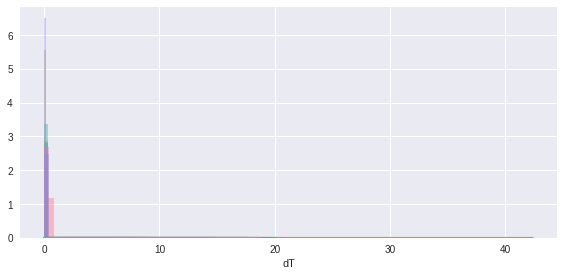

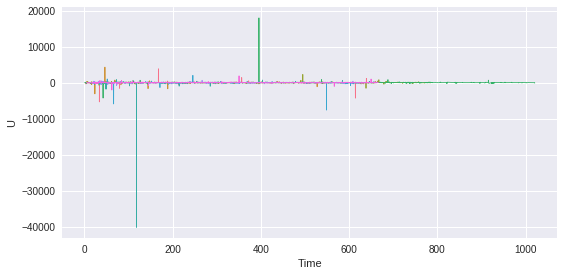

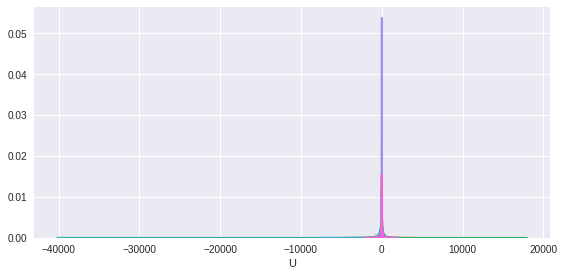

In [7]:
## ANGULAR VELOCITY and dT IN Y AXIS
g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'dT');

# calculated
g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)
g.map(plt.plot, "Time", "U", alpha=1, linewidth=0.8);
g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)
g.map(sns.distplot, 'U');


In [8]:
## FILTERING HIGH DATA

dfOriU = pd.DataFrame()

dfOri2 = dfOri2[np.absolute(dfOri2['dT']) < 0.005] # filtering out big time gaps frame points
# dfOri2 = dfOri2[np.absolute(dfOri2['U'])  < 600]   # too big velocities removal

for name, dd in dfOri2.groupby('session_id'):
    dd['UM'] = dd['U'].rolling(window=20).mean()
    dfOriU = pd.concat([dfOriU, dd], axis=0, ignore_index=True)    

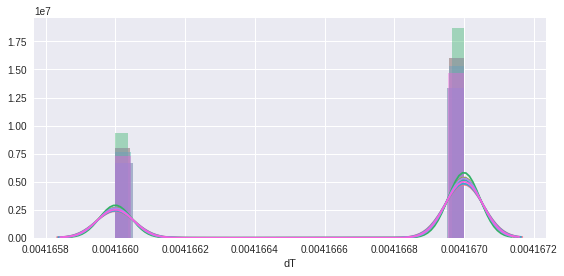

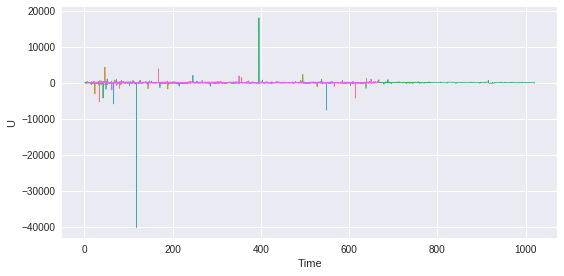

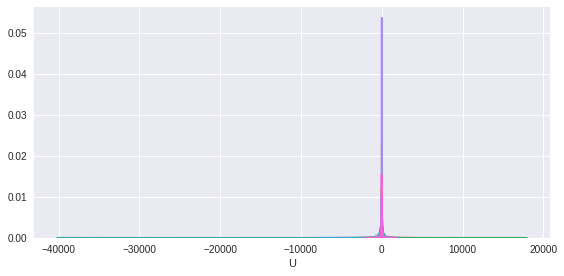

In [9]:
# filtered
g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'dT');

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=0.8);
g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'U');


## Stimulus-related behavior
Looking for frames detected as SRB.

SRB = {f E FRAMES: ||Vhead - Vstim|| < Dmax}

In [10]:
# ## COMPARISON WITH EVENT DATA
# remove unused columns
dfOri3 = dfOriU.drop({'lx1', 'lz1', 'V1', 'lVo', 'theta'}, axis=1)
dfeventsClean = dfevent.drop({'MotiveExpTimeSecs'}, axis=1)

dfV = pd.merge(dfOri3, dfeventsClean, on=['Time', 'session_id','Frame'])

In [11]:
dfV['subUM']  = dfV['speed'] - dfV['UM'] 
dfV['subU']   = dfV['speed'] - dfV['U'] 
dfV = dfV.replace([np.inf, -np.inf], np.nan).dropna()

In [12]:
dfV.head()

,Frame,Time,X_Pos,Y_Pos,Z_Pos,X_Ori,Y_Ori,Z_Ori,session_id,dT,lx2,lz2,clockwise,U,UM,visible,speed,subUM,subU
19,907,3.779167,0.082251,0.097748,0.018838,0.611803,-0.297856,0.200758,0,0.004167,0.945474,0.325696,-1,-201.823034,-278.179751,0,0.0,278.179751,201.823034
20,908,3.783334,0.083167,0.097571,0.018337,0.620593,-0.299306,0.193899,0,0.004167,0.950153,0.311784,-1,-195.782514,-269.584462,0,0.0,269.584462,195.782514
21,909,3.787500,0.084063,0.097393,0.017829,0.629216,-0.300646,0.187091,0,0.004166,0.954496,0.298224,-1,-190.018097,-261.113085,0,0.0,261.113085,190.018097
22,910,3.791667,0.084938,0.097214,0.017314,0.637673,-0.301872,0.180336,0,0.004167,0.958525,0.285008,-1,-184.362713,-252.773581,0,0.0,252.773581,184.362713
23,913,3.804167,0.086626,0.096853,0.016266,0.654088,-0.303982,0.166978,0,0.004167,0.965721,0.259582,-1,-173.842972,-244.332175,0,0.0,244.332175,173.842972


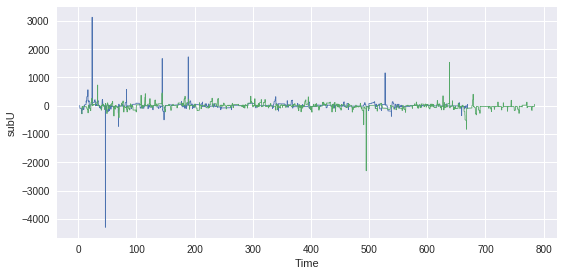

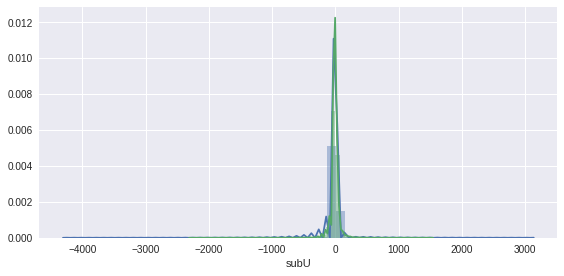

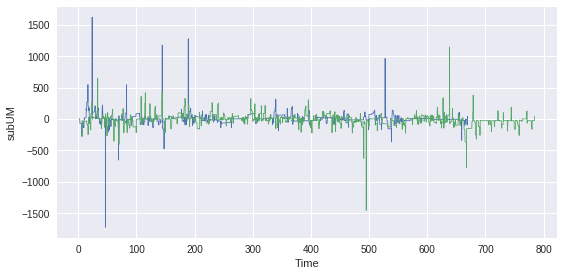

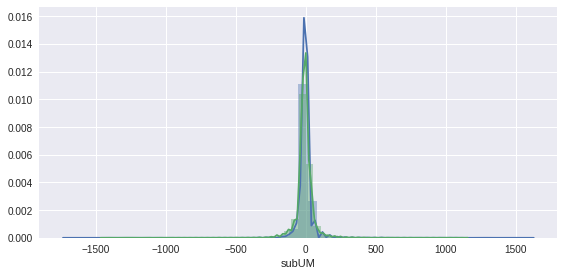

In [13]:
## ANGULAR VELOCITY IN Y AXIS

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(sns.distplot, 'subU');

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "subUM", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(sns.distplot, 'subUM');


In [14]:
# setting Dmax as 20% of velocity at given moment // what about 0
DmaxPerc = 0.5
dfV['Dmax'] = dfV.speed * DmaxPerc
# dfV['Dmax'] = lambda dfV: 0.1 if dfV.Dmax == 0 else dfV.Dmax

dfV['SRB_U']   = np.absolute(dfV['subU'].values)  < np.absolute(dfV['Dmax'].values)

dfV['SRB_UM']  = np.absolute(dfV['subUM'].values) < np.absolute(dfV['Dmax'].values)
sumFrame = len(dfV.Frame)

# checking lenght of SRB frames in the filtered experiment data
sumSRB_UM = len(dfV[dfV['SRB_UM']])
print('stimulus-related behavior UM : %f%%' % (sumSRB_UM  * 100 / sumFrame))

## SRB PER EXPERIMENT
sumFrameexp  = {}
sumSRBexp_UM = {}
sumSRBexp_U  = {}

for i, dd in dfV.groupby('session_id'):
    sumFrameexp[i] = len(dd.Frame)    
    sumSRBexp_U[i] = len(dd[dd['SRB_U']])
    print('stimulus-related behavior exp %d UM : %f%%'  % (i, sumSRBexp_U[i]  * 100 / sumFrameexp[i]))

print()
for i, dd in dfV.groupby('session_id'):
    sumSRBexp_UM[i] = len(dd[dd['SRB_UM']])    
    print('stimulus-related behavior exp %d UM : %f%%'  % (i, sumSRBexp_UM[i]  * 100 / sumFrameexp[i]))


stimulus-related behavior UM : 4.749040%
stimulus-related behavior exp 0 UM : 4.601567%
stimulus-related behavior exp 1 UM : 2.394148%
stimulus-related behavior exp 2 UM : 4.562962%
stimulus-related behavior exp 3 UM : 4.306778%
stimulus-related behavior exp 4 UM : 6.376563%
stimulus-related behavior exp 5 UM : 5.206278%
stimulus-related behavior exp 6 UM : 5.818228%
stimulus-related behavior exp 7 UM : 5.289463%

stimulus-related behavior exp 0 UM : 4.611970%
stimulus-related behavior exp 1 UM : 2.417649%
stimulus-related behavior exp 2 UM : 4.566587%
stimulus-related behavior exp 3 UM : 4.327128%
stimulus-related behavior exp 4 UM : 6.407877%
stimulus-related behavior exp 5 UM : 5.248567%
stimulus-related behavior exp 6 UM : 5.889217%
stimulus-related behavior exp 7 UM : 5.307926%


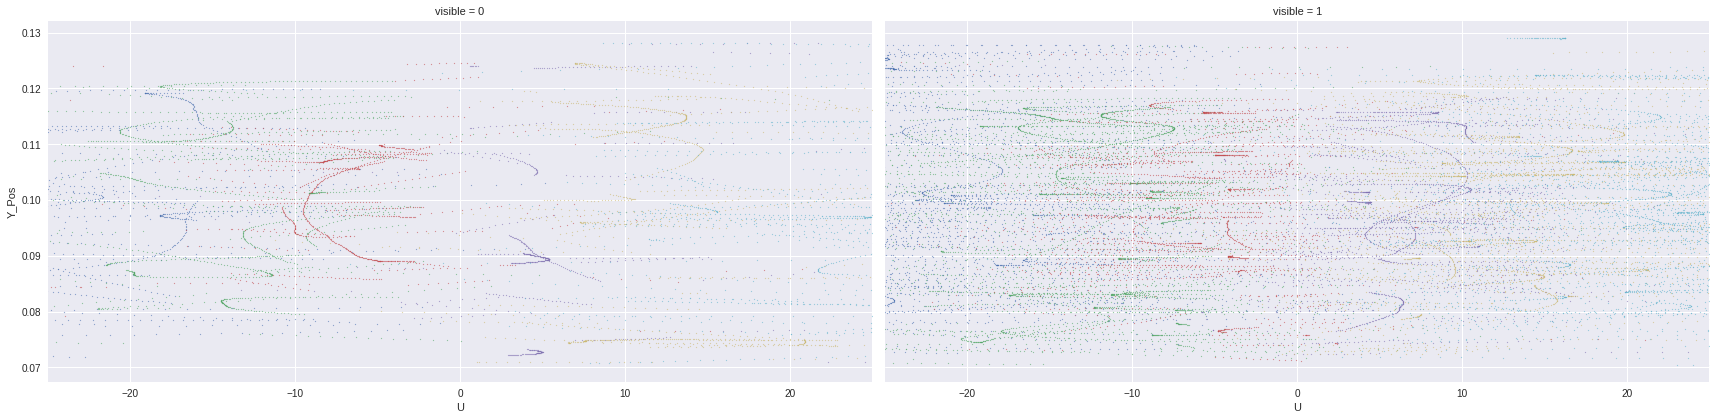

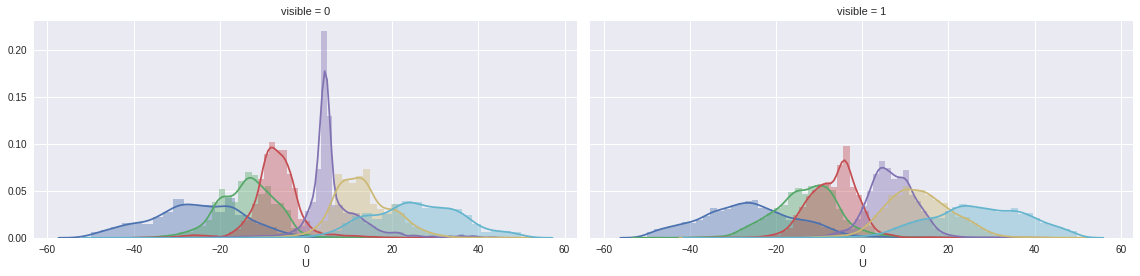

In [15]:
g = sns.FacetGrid( data=dfV[dfV['SRB_UM']], size=6, aspect=2, xlim=[-25,25], col='visible', hue='speed')
g.map(plt.scatter,'U', "Y_Pos", alpha=0.5, s=1);

g = sns.FacetGrid( data=dfV[(dfV['SRB_UM']) & (np.absolute(dfV['U'])<50)], col='visible', size=4, aspect=2, hue='speed')#, hue_order=[1,2])
g.map(sns.distplot, 'U');

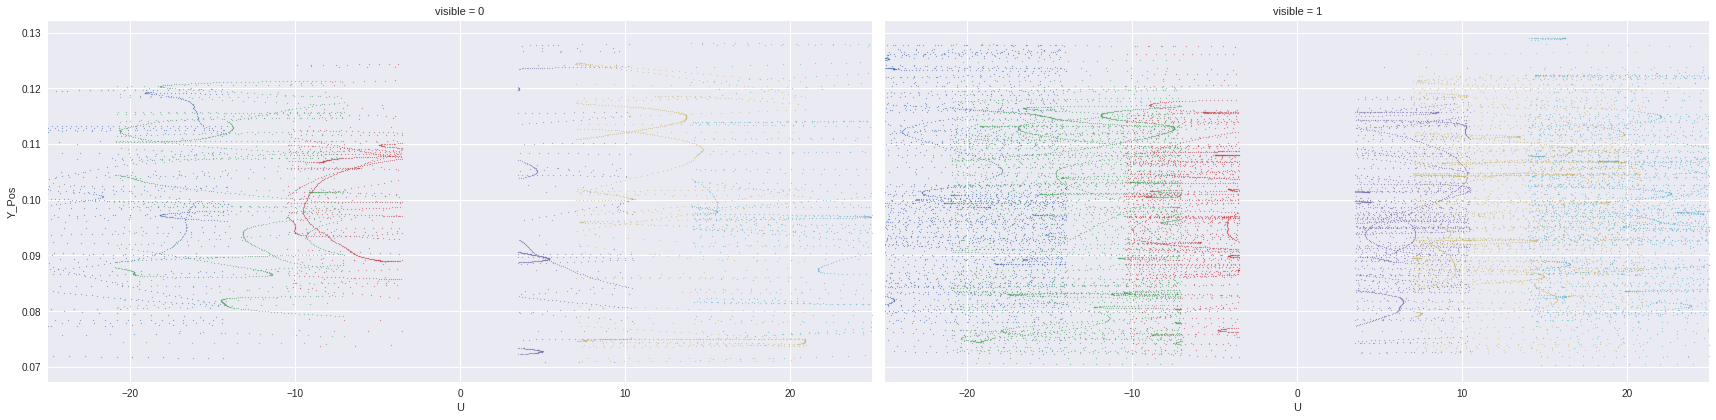

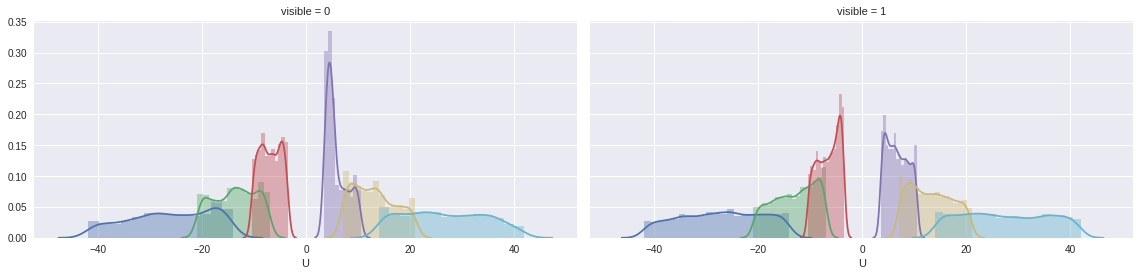

In [16]:
g = sns.FacetGrid( data=dfV[dfV['SRB_U']], size=6, aspect=2, xlim=[-25,25], col='visible', hue='speed')
g.map(plt.scatter,'U', "Y_Pos", alpha=0.5, s=1);

g = sns.FacetGrid( data=dfV[(dfV['SRB_U']) & (np.absolute(dfV['U'])<50)], col='visible', size=4, aspect=2, hue='speed')#, hue_order=[1,2])
g.map(sns.distplot, 'U');
